In [1]:
import illustris_python as il
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests
import tempfile
import h5py
import seaborn as sns
import itertools
from astropy.cosmology import Planck15 as cosmo
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline

In [2]:
def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    
    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string
    
    return r

In [3]:
sim_name = "TNG50-1"
basePath = 'sims.TNG/TNG50-1/output'
field=['SubhaloHalfmassRadType','SubhaloFlag','SubhaloSFR','SubhaloMassInRadType']
baseUrl = 'http://www.tng-project.org/api/TNG50-1/snapshots/'
headers={"api-key":"29fdb501f084ab3bde756d4827030bcb"}

In [4]:
simulationHeader = get('http://www.tng-project.org/api/'+sim_name)
simulationHeader['cosmology']

'Planck2015'

In [5]:
snaps=get(baseUrl)
snaprs=[(snaps[i]['number'],snaps[i]['redshift']) for i in range(len(snaps))]
snaprs[95:]

[(95, 0.0485236299818059),
 (96, 0.0337243718735154),
 (97, 0.0239744283827625),
 (98, 0.00952166696794476),
 (99, 2.22044604925031e-16)]

In [6]:
data=il.groupcat.loadSubhalos(basePath,99,fields=field)

In [7]:
h=0.6774

def assign_fields(data,rs):
    ms=data['SubhaloMassInRadType'][:,4]*1e10/h
    r=data['SubhaloHalfmassRadType'][:,4]/h
    sfr=data['SubhaloSFR']
    z=rs*np.ones(len(ms))
    flags=data['SubhaloFlag']
    ids=np.array(list(range(len(ms))))
    
    good_ones=np.where((flags==True) &(ms > 0) & (sfr > 0))
    fields=[ms,r,sfr,z,flags,ids]
    newfields=[field[good_ones] for field in fields]
    ms,r,sfr,z,flags,ids=newfields
    
    log_ms=np.log10(ms)
    log_sfr=np.log10(sfr)

    req_range=np.where((log_ms>8)&(log_ms<11.5))

    fields=[ms,r,sfr,z,flags,ids]
    newfields=[field[req_range] for field in fields]
    ms,r,sfr,z,flags,ids=newfields
    
    return ms,r,sfr,z,flags,ids

In [8]:
ms,r,sfr,z,flags,ids=assign_fields(data,0)
log_ms=np.log10(ms)
log_sfr=np.log10(sfr)

In [9]:
def speagle(logmass,z):
    t=cosmo.age(0).value
    slope=0.84-0.026*t
    intercept=6.51-0.11*t
    return slope*(logmass)-intercept

def chang(logmass):
    return 0.8*logmass-8.23

def renzini(logmass):
    return 0.76*logmass-7.64    

In [10]:
def compare_mainseq(log_ms,log_sfr,z):
    x = np.linspace(8, 11.5, len(log_ms))

    data = {'log_ms': log_ms, 'log_sfr': log_sfr, 'chang':chang(x),'speagle':speagle(x,z),'renzini':renzini(x),'x':x}
    df = pd.DataFrame(data)

    plt.figure(figsize=(5,4))
    sns.scatterplot(data=df, x='log_ms', y='log_sfr', s=3, label='Data')
    sns.lineplot(df,x='x',y='speagle', label='Speagle+14', linewidth=2, color='brown')
    sns.lineplot(df,x='x',y='chang', label='Chang+15', linewidth=2, color='blue')
    sns.lineplot(df,x='x',y='renzini', label='Renzini&Peng15', linewidth=2, color='black')

    plt.xlabel('log Galaxy Stellar Mass [$M_\\odot$, $r < R_{eff}$]')
    plt.ylabel('log Star Formation Rate [yr$^{-1}$]')
    plt.legend()
    plt.show()

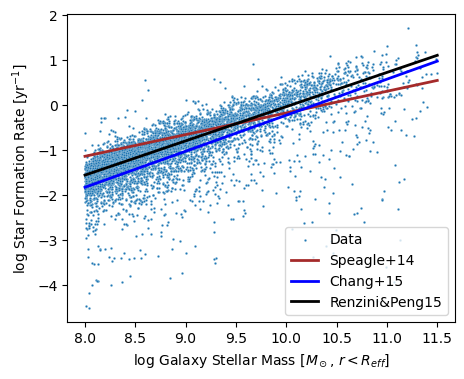

In [11]:
compare_mainseq(log_ms,log_sfr,0)

In [12]:
good_ones=np.where((abs(renzini(log_ms)-log_sfr)<0.6))
fields=[ms,r,sfr,z,flags,ids]
newfields=[field[good_ones] for field in fields]
ms,r,sfr,z,flags,ids=newfields

In [13]:
log_ms=np.log10(ms)
log_sfr=np.log10(sfr)

In [14]:
def bins(log_ms,log_sfr,nbins):
    mass_bins=np.linspace(log_ms.min(),log_ms.max(),nbins+1,endpoint=True)
    bin_indices=np.digitize(log_ms, mass_bins, right=False)
    binned_data={bin_start:[] for bin_start in mass_bins[0:-1]}

    for i, bin_start in enumerate(mass_bins[0:]):
        mask=bin_indices==i+1
        binned_data[bin_start]=list(zip(log_ms[mask],log_sfr[mask]))
    
    return mass_bins,binned_data

In [15]:
mass_bins,binned_data=bins(log_ms,log_sfr,15)
logms_to_plot=[(mass_bins[i]+mass_bins[i+1])/2 for i in range(len(mass_bins)-1)]
logsfr_to_plot = [np.median([i[1] for i in binned_data[bin_start]]) for bin_start in mass_bins[0:-1]]
std_logsfr = [np.std([i[1] for i in binned_data[bin_start]]) for bin_start in mass_bins[0:-1]]

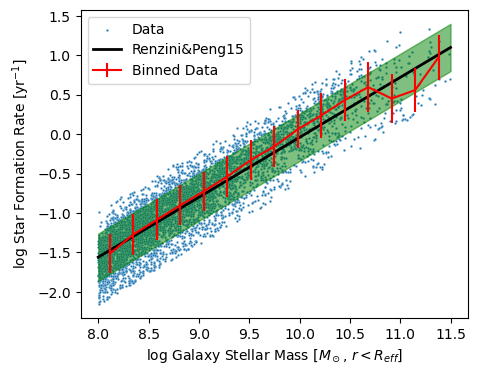

In [16]:
x=np.linspace(8,11.5,len(log_ms))
cs1=CubicSpline(x,renzini(x)+0.3)
cs2=CubicSpline(x,renzini(x)-0.3)

data = {'log_ms': log_ms, 'log_sfr': log_sfr}
data2={'renzini':renzini(x),'x':x}
df = pd.DataFrame(data)
df2=pd.DataFrame(data2)

plt.figure(figsize=(5,4))
sns.scatterplot(data=df, x='log_ms', y='log_sfr', s=3, label='Data')
sns.lineplot(df2,x='x',y='renzini', label='Renzini&Peng15', linewidth=2, color='black')
plt.errorbar(x=logms_to_plot, y=logsfr_to_plot, yerr=std_logsfr, color='red',label='Binned Data')
plt.fill_between(x,cs1(x),cs2(x),alpha=0.5,color='green')

plt.xlabel('log Galaxy Stellar Mass [$M_\\odot$, $r < R_{eff}$]')
plt.ylabel('log Star Formation Rate [yr$^{-1}$]')
plt.legend()
plt.show()

In [17]:
def line(x,m,c):
    return m*x+c

popt,pcov=curve_fit(line,logms_to_plot,logsfr_to_plot)

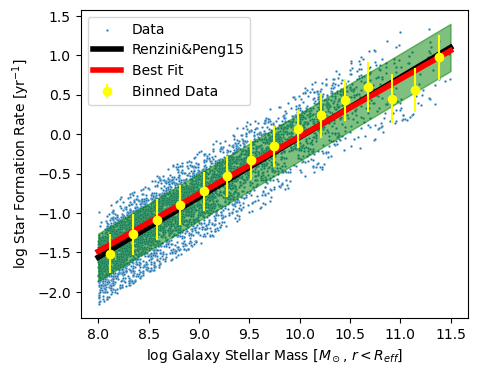

In [18]:
data2={'renzini':renzini(x),'x':x,'lin':line(x,popt[0],popt[1])}
df2=pd.DataFrame(data2)

plt.figure(figsize=(5,4))
sns.scatterplot(data=df, x='log_ms', y='log_sfr', s=3, label='Data')
sns.lineplot(df2,x='x',y='renzini', label='Renzini&Peng15', linewidth=4, color='black')
sns.lineplot(df2,x='x',y='lin', label='Best Fit', linewidth=4, color='red')
plt.fill_between(x,cs1(x),cs2(x),alpha=0.5,color='green')
plt.errorbar(x=logms_to_plot, y=logsfr_to_plot, yerr=std_logsfr, fmt='o', color='yellow',label='Binned Data')

plt.xlabel('log Galaxy Stellar Mass [$M_\\odot$, $r < R_{eff}$]')
plt.ylabel('log Star Formation Rate [yr$^{-1}$]')
plt.legend()
plt.show()

In [19]:
def select_r(ms,r,sfr,z,flags,ids):
    good_ones=np.where(r > 0)
    fields=[ms,r,sfr,z,flags,ids]

    newfields=[field[good_ones] for field in fields]
    ms,r,sfr,z,flags,ids=newfields
    
    return ms,r,sfr,z,flags,ids

In [20]:
ms,r,sfr,z,flags,ids=select_r(ms,r,sfr,z,flags,ids)

In [21]:
all_ms=np.array([])
all_r=np.array([])
all_sfr=np.array([])
all_z=np.array([])
all_id=np.array([])

In [22]:
all_ms=np.concatenate((all_ms,ms))
all_r=np.concatenate((all_r,r))
all_sfr=np.concatenate((all_sfr,sfr))
all_z=np.concatenate((all_z,z))
all_id=np.concatenate((all_id,ids))

In [23]:
data=il.groupcat.loadSubhalos(basePath,98,fields=['SubhaloHalfmassRadType','SubhaloFlag','SubhaloSFR','SubhaloMassInRadType'])

In [24]:
ms,r,sfr,z,flags,ids=assign_fields(data,0.01)
log_ms=np.log10(ms)
log_sfr=np.log10(sfr)

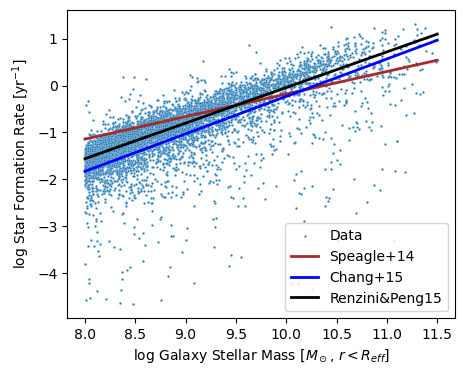

In [25]:
compare_mainseq(log_ms,log_sfr,0.01)

In [26]:
good_ones=np.where((abs(renzini(log_ms)-log_sfr)<0.6))
fields=[ms,r,sfr,z,flags,ids]
newfields=[field[good_ones] for field in fields]
ms,r,sfr,z,flags,ids=newfields

In [27]:
log_ms=np.log10(ms)
log_sfr=np.log10(sfr)

In [28]:
mass_bins,binned_data=bins(log_ms,log_sfr,15)
logms_to_plot=[(mass_bins[i]+mass_bins[i+1])/2 for i in range(len(mass_bins)-1)]
logsfr_to_plot = [np.median([i[1] for i in binned_data[bin_start]]) for bin_start in mass_bins[0:-1]]
std_logsfr = [np.std([i[1] for i in binned_data[bin_start]]) for bin_start in mass_bins[0:-1]]

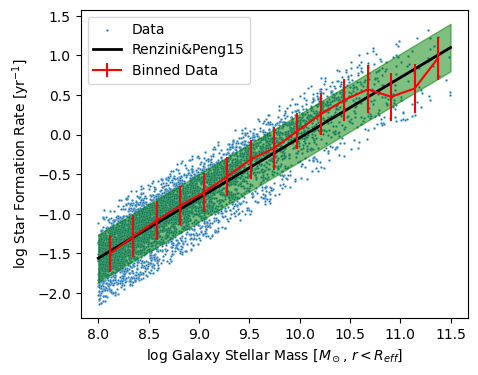

In [29]:
x=np.linspace(8,11.5,len(log_ms))
cs1=CubicSpline(x,renzini(x)+0.3)
cs2=CubicSpline(x,renzini(x)-0.3)

data = {'log_ms': log_ms, 'log_sfr': log_sfr}
data2={'renzini':renzini(x),'x':x}
df = pd.DataFrame(data)
df2=pd.DataFrame(data2)

plt.figure(figsize=(5,4))
sns.scatterplot(data=df, x='log_ms', y='log_sfr', s=3, label='Data')
sns.lineplot(df2,x='x',y='renzini', label='Renzini&Peng15', linewidth=2, color='black')
plt.errorbar(x=logms_to_plot, y=logsfr_to_plot, yerr=std_logsfr, color='red',label='Binned Data')
plt.fill_between(x,cs1(x),cs2(x),alpha=0.5,color='green')

plt.xlabel('log Galaxy Stellar Mass [$M_\\odot$, $r < R_{eff}$]')
plt.ylabel('log Star Formation Rate [yr$^{-1}$]')
plt.legend()
plt.show()

In [30]:
popt,pcov=curve_fit(line,logms_to_plot,logsfr_to_plot)

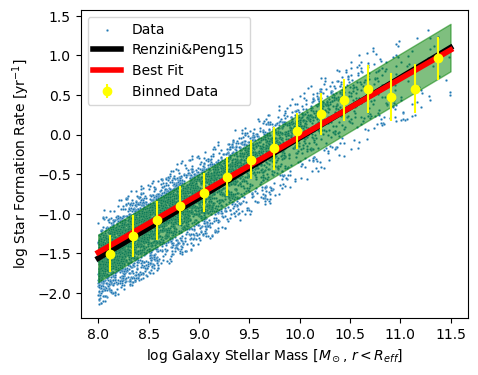

In [31]:
data2={'renzini':renzini(x),'x':x,'lin':line(x,popt[0],popt[1])}
df2=pd.DataFrame(data2)

plt.figure(figsize=(5,4))
sns.scatterplot(data=df, x='log_ms', y='log_sfr', s=3, label='Data')
sns.lineplot(df2,x='x',y='renzini', label='Renzini&Peng15', linewidth=4, color='black')
sns.lineplot(df2,x='x',y='lin', label='Best Fit', linewidth=4, color='red')
plt.fill_between(x,cs1(x),cs2(x),alpha=0.5,color='green')
plt.errorbar(x=logms_to_plot, y=logsfr_to_plot, yerr=std_logsfr, fmt='o', color='yellow',label='Binned Data')

plt.xlabel('log Galaxy Stellar Mass [$M_\\odot$, $r < R_{eff}$]')
plt.ylabel('log Star Formation Rate [yr$^{-1}$]')
plt.legend()
plt.show()

In [32]:
ms,r,sfr,z,flags,ids=select_r(ms,r,sfr,z,flags,ids)

In [33]:
all_ms=np.concatenate((all_ms,ms))
all_r=np.concatenate((all_r,r))
all_sfr=np.concatenate((all_sfr,sfr))
all_z=np.concatenate((all_z,z))
all_id=np.concatenate((all_id,ids))

In [34]:
data=il.groupcat.loadSubhalos(basePath,97,fields=field)

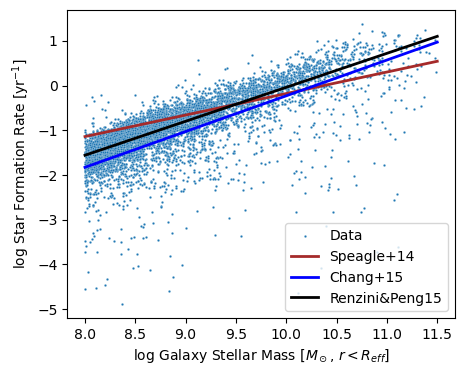

In [35]:
ms,r,sfr,z,flags,ids=assign_fields(data,0.024)
log_ms=np.log10(ms)
log_sfr=np.log10(sfr)
compare_mainseq(log_ms,log_sfr,0.024)

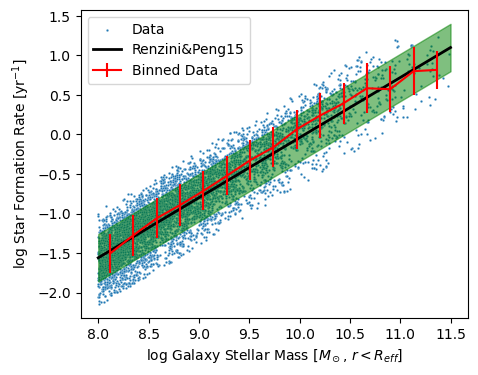

In [36]:
good_ones=np.where((abs(renzini(log_ms)-log_sfr)<0.6))
fields=[ms,r,sfr,z,flags,ids]
newfields=[field[good_ones] for field in fields]
ms,r,sfr,z,flags,ids=newfields
log_ms=np.log10(ms)
log_sfr=np.log10(sfr)
mass_bins,binned_data=bins(log_ms,log_sfr,15)
logms_to_plot=[(mass_bins[i]+mass_bins[i+1])/2 for i in range(len(mass_bins)-1)]
logsfr_to_plot = [np.median([i[1] for i in binned_data[bin_start]]) for bin_start in mass_bins[0:-1]]
std_logsfr = [np.std([i[1] for i in binned_data[bin_start]]) for bin_start in mass_bins[0:-1]]
x=np.linspace(8,11.5,len(log_ms))
cs1=CubicSpline(x,renzini(x)+0.3)
cs2=CubicSpline(x,renzini(x)-0.3)

data = {'log_ms': log_ms, 'log_sfr': log_sfr}
data2={'renzini':renzini(x),'x':x}
df = pd.DataFrame(data)
df2=pd.DataFrame(data2)

plt.figure(figsize=(5,4))
sns.scatterplot(data=df, x='log_ms', y='log_sfr', s=3, label='Data')
sns.lineplot(df2,x='x',y='renzini', label='Renzini&Peng15', linewidth=2, color='black')
plt.errorbar(x=logms_to_plot, y=logsfr_to_plot, yerr=std_logsfr, color='red',label='Binned Data')
plt.fill_between(x,cs1(x),cs2(x),alpha=0.5,color='green')

plt.xlabel('log Galaxy Stellar Mass [$M_\\odot$, $r < R_{eff}$]')
plt.ylabel('log Star Formation Rate [yr$^{-1}$]')
plt.legend()
plt.show()

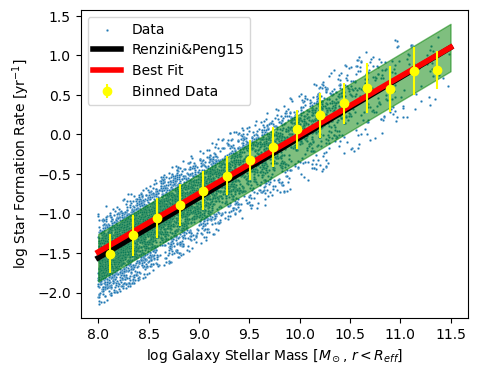

In [37]:
popt,pcov=curve_fit(line,logms_to_plot,logsfr_to_plot)
data2={'renzini':renzini(x),'x':x,'lin':line(x,popt[0],popt[1])}
df2=pd.DataFrame(data2)

plt.figure(figsize=(5,4))
sns.scatterplot(data=df, x='log_ms', y='log_sfr', s=3, label='Data')
sns.lineplot(df2,x='x',y='renzini', label='Renzini&Peng15', linewidth=4, color='black')
sns.lineplot(df2,x='x',y='lin', label='Best Fit', linewidth=4, color='red')
plt.fill_between(x,cs1(x),cs2(x),alpha=0.5,color='green')
plt.errorbar(x=logms_to_plot, y=logsfr_to_plot, yerr=std_logsfr, fmt='o', color='yellow',label='Binned Data')

plt.xlabel('log Galaxy Stellar Mass [$M_\\odot$, $r < R_{eff}$]')
plt.ylabel('log Star Formation Rate [yr$^{-1}$]')
plt.legend()
plt.show()

In [38]:
ms,r,sfr,z,flags,ids=select_r(ms,r,sfr,z,flags,ids)
all_ms=np.concatenate((all_ms,ms))
all_r=np.concatenate((all_r,r))
all_sfr=np.concatenate((all_sfr,sfr))
all_z=np.concatenate((all_z,z))
all_id=np.concatenate((all_id,ids))

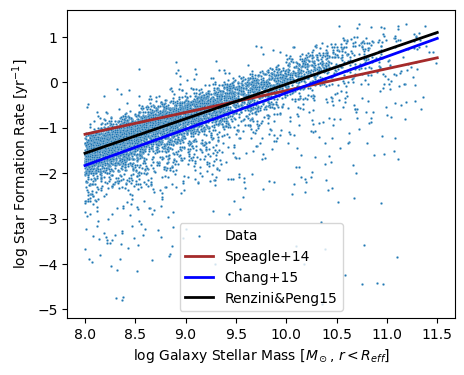

In [39]:
data=il.groupcat.loadSubhalos(basePath,96,fields=field)
ms,r,sfr,z,flags,ids=assign_fields(data,0.034)
log_ms=np.log10(ms)
log_sfr=np.log10(sfr)
compare_mainseq(log_ms,log_sfr,0.034)

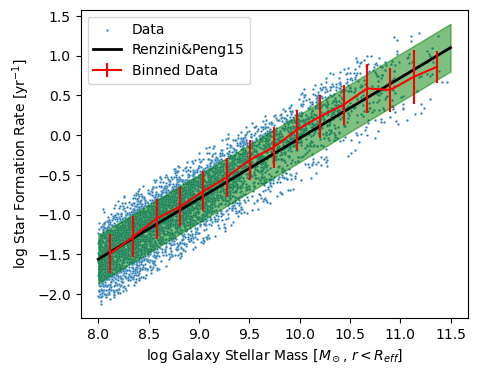

In [40]:
good_ones=np.where((abs(renzini(log_ms)-log_sfr)<0.6))
fields=[ms,r,sfr,z,flags,ids]
newfields=[field[good_ones] for field in fields]
ms,r,sfr,z,flags,ids=newfields
log_ms=np.log10(ms)
log_sfr=np.log10(sfr)
mass_bins,binned_data=bins(log_ms,log_sfr,15)
logms_to_plot=[(mass_bins[i]+mass_bins[i+1])/2 for i in range(len(mass_bins)-1)]
logsfr_to_plot = [np.median([i[1] for i in binned_data[bin_start]]) for bin_start in mass_bins[0:-1]]
std_logsfr = [np.std([i[1] for i in binned_data[bin_start]]) for bin_start in mass_bins[0:-1]]
x=np.linspace(8,11.5,len(log_ms))
cs1=CubicSpline(x,renzini(x)+0.3)
cs2=CubicSpline(x,renzini(x)-0.3)

data = {'log_ms': log_ms, 'log_sfr': log_sfr}
data2={'renzini':renzini(x),'x':x}
df = pd.DataFrame(data)
df2=pd.DataFrame(data2)

plt.figure(figsize=(5,4))
sns.scatterplot(data=df, x='log_ms', y='log_sfr', s=3, label='Data')
sns.lineplot(df2,x='x',y='renzini', label='Renzini&Peng15', linewidth=2, color='black')
plt.errorbar(x=logms_to_plot, y=logsfr_to_plot, yerr=std_logsfr, color='red',label='Binned Data')
plt.fill_between(x,cs1(x),cs2(x),alpha=0.5,color='green')

plt.xlabel('log Galaxy Stellar Mass [$M_\\odot$, $r < R_{eff}$]')
plt.ylabel('log Star Formation Rate [yr$^{-1}$]')
plt.legend()
plt.show()

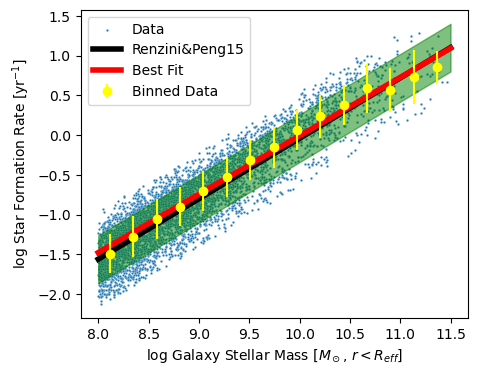

In [41]:
popt,pcov=curve_fit(line,logms_to_plot,logsfr_to_plot)
data2={'renzini':renzini(x),'x':x,'lin':line(x,popt[0],popt[1])}
df2=pd.DataFrame(data2)

plt.figure(figsize=(5,4))
sns.scatterplot(data=df, x='log_ms', y='log_sfr', s=3, label='Data')
sns.lineplot(df2,x='x',y='renzini', label='Renzini&Peng15', linewidth=4, color='black')
sns.lineplot(df2,x='x',y='lin', label='Best Fit', linewidth=4, color='red')
plt.fill_between(x,cs1(x),cs2(x),alpha=0.5,color='green')
plt.errorbar(x=logms_to_plot, y=logsfr_to_plot, yerr=std_logsfr, fmt='o', color='yellow',label='Binned Data')

plt.xlabel('log Galaxy Stellar Mass [$M_\\odot$, $r < R_{eff}$]')
plt.ylabel('log Star Formation Rate [yr$^{-1}$]')
plt.legend()
plt.show()

In [42]:
ms,r,sfr,z,flags,ids=select_r(ms,r,sfr,z,flags,ids)
all_ms=np.concatenate((all_ms,ms))
all_r=np.concatenate((all_r,r))
all_sfr=np.concatenate((all_sfr,sfr))
all_z=np.concatenate((all_z,z))
all_id=np.concatenate((all_id,ids))

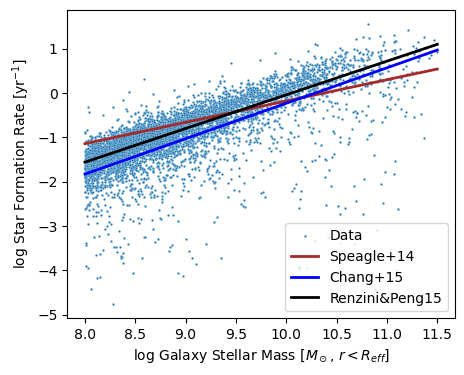

In [43]:
data=il.groupcat.loadSubhalos(basePath,95,fields=field)
ms,r,sfr,z,flags,ids=assign_fields(data,0.049)
log_ms=np.log10(ms)
log_sfr=np.log10(sfr)
compare_mainseq(log_ms,log_sfr,0.049)

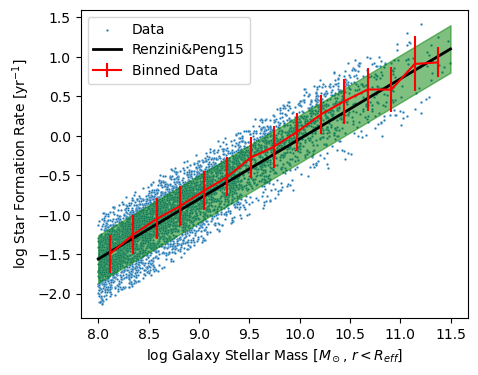

In [44]:
good_ones=np.where((abs(renzini(log_ms)-log_sfr)<0.6))
fields=[ms,r,sfr,z,flags,ids]
newfields=[field[good_ones] for field in fields]
ms,r,sfr,z,flags,ids=newfields
log_ms=np.log10(ms)
log_sfr=np.log10(sfr)
mass_bins,binned_data=bins(log_ms,log_sfr,15)
logms_to_plot=[(mass_bins[i]+mass_bins[i+1])/2 for i in range(len(mass_bins)-1)]
logsfr_to_plot = [np.median([i[1] for i in binned_data[bin_start]]) for bin_start in mass_bins[0:-1]]
std_logsfr = [np.std([i[1] for i in binned_data[bin_start]]) for bin_start in mass_bins[0:-1]]
x=np.linspace(8,11.5,len(log_ms))
cs1=CubicSpline(x,renzini(x)+0.3)
cs2=CubicSpline(x,renzini(x)-0.3)

data = {'log_ms': log_ms, 'log_sfr': log_sfr}
data2={'renzini':renzini(x),'x':x}
df = pd.DataFrame(data)
df2=pd.DataFrame(data2)

plt.figure(figsize=(5,4))
sns.scatterplot(data=df, x='log_ms', y='log_sfr', s=3, label='Data')
sns.lineplot(df2,x='x',y='renzini', label='Renzini&Peng15', linewidth=2, color='black')
plt.errorbar(x=logms_to_plot, y=logsfr_to_plot, yerr=std_logsfr, color='red',label='Binned Data')
plt.fill_between(x,cs1(x),cs2(x),alpha=0.5,color='green')

plt.xlabel('log Galaxy Stellar Mass [$M_\\odot$, $r < R_{eff}$]')
plt.ylabel('log Star Formation Rate [yr$^{-1}$]')
plt.legend()
plt.show()

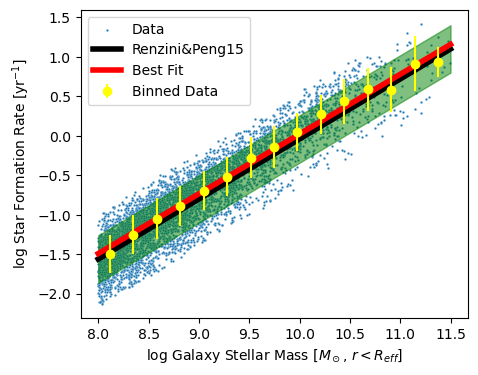

In [45]:
popt,pcov=curve_fit(line,logms_to_plot,logsfr_to_plot)
data2={'renzini':renzini(x),'x':x,'lin':line(x,popt[0],popt[1])}
df2=pd.DataFrame(data2)

plt.figure(figsize=(5,4))
sns.scatterplot(data=df, x='log_ms', y='log_sfr', s=3, label='Data')
sns.lineplot(df2,x='x',y='renzini', label='Renzini&Peng15', linewidth=4, color='black')
sns.lineplot(df2,x='x',y='lin', label='Best Fit', linewidth=4, color='red')
plt.fill_between(x,cs1(x),cs2(x),alpha=0.5,color='green')
plt.errorbar(x=logms_to_plot, y=logsfr_to_plot, yerr=std_logsfr, fmt='o', color='yellow',label='Binned Data')

plt.xlabel('log Galaxy Stellar Mass [$M_\\odot$, $r < R_{eff}$]')
plt.ylabel('log Star Formation Rate [yr$^{-1}$]')
plt.legend()
plt.show()

In [46]:
ms,r,sfr,z,flags,ids=select_r(ms,r,sfr,z,flags,ids)
all_ms=np.concatenate((all_ms,ms))
all_r=np.concatenate((all_r,r))
all_sfr=np.concatenate((all_sfr,sfr))
all_z=np.concatenate((all_z,z))
all_id=np.concatenate((all_id,ids))

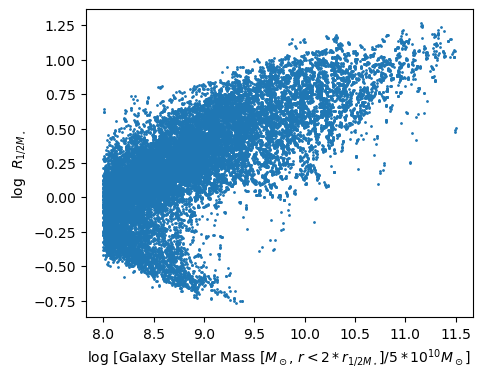

In [48]:
log_ms=np.log10(all_ms)
log_r=np.log10(all_r)
fig=plt.figure(figsize=(5,4))
ax=fig.add_subplot(111)
ax.plot(log_ms,log_r,'.',markersize=2)

ax.set_xlabel('log [Galaxy Stellar Mass [$M_\odot$, $r < 2*r_{1/2 M_\star}]/5*10^{10}M_\odot$]')
ax.set_ylabel('log  $R_{1/2 M_\star}$')
plt.show()

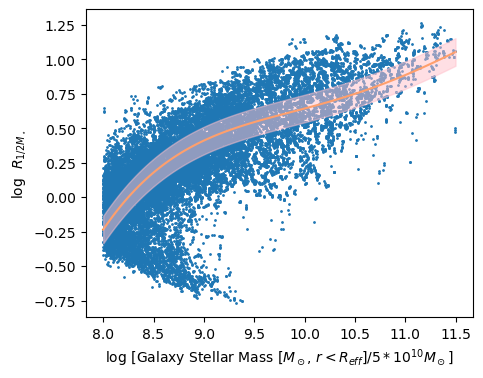

In [50]:
x=9.00507614213198, 9.302030456852792, 9.598984771573605, 9.898477157360405, 10.200507614213198, 10.50253807106599, 10.802030456852792, 11.101522842639593, 11.403553299492385 
y=0.4129205921938089,0.4979811574697174,0.570121130551817,0.619650067294751,0.682099596231494,0.7574697173620457,0.8242261103633917,0.9189771197846568,1.0201884253028264
x=np.array(x)
y=np.array(y)
z=np.poly1d(np.polyfit(x,y,4))

fig=plt.figure(figsize=(5,4))
ax=fig.add_subplot(111)
x_values=np.linspace(8,11.5,100)
ax.plot(log_ms,log_r,'.',markersize=2)
ax.plot(x_values,z(x_values))
ax.fill_between(x_values,z(x_values)+0.1,z(x_values)-0.1,color='pink',alpha=0.5,zorder=2)

ax.set_xlabel('log [Galaxy Stellar Mass [$M_\odot$, $r < R_{eff}]/5*10^{10}M_\odot$]')
ax.set_ylabel('log  $R_{1/2 M_\star}$')
plt.show()

In [57]:
good_ones=np.where(abs(z(log_ms)-log_r)<=0.2)
fields=[all_ms,all_r,all_sfr,all_z,all_id]

newfields=[field[good_ones] for field in fields]
all_ms,all_r,all_sfr,all_z,all_id=newfields

In [58]:
log_ms=np.log10(all_ms)
log_r=np.log10(all_r)

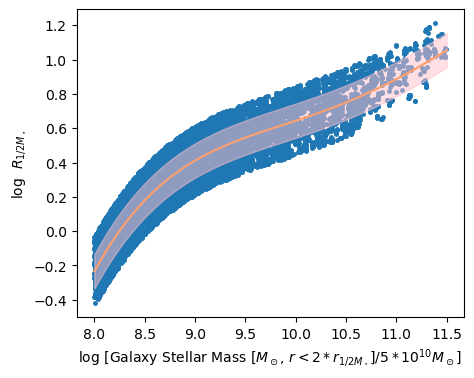

In [59]:
fig=plt.figure(figsize=(5,4))
ax=fig.add_subplot(111)
ax.plot(log_ms,log_r,'.',markersize=5)
ax.plot(x_values,z(x_values))
ax.fill_between(x_values,z(x_values)+0.1,z(x_values)-0.1,color='pink',alpha=0.5,zorder=2)

ax.set_xlabel('log [Galaxy Stellar Mass [$M_\odot$, $r < 2*r_{1/2 M_\star}]/5*10^{10}M_\odot$]')
ax.set_ylabel('log  $R_{1/2 M_\star}$')
plt.show()

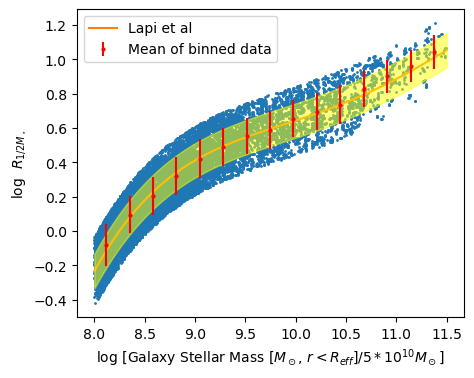

In [63]:
mass_bins,binned_data=bins(log_ms,log_r,15)
logms_to_plot=[(mass_bins[i]+mass_bins[i+1])/2 for i in range(len(mass_bins)-1)]
logr_to_plot = [np.mean([i[1] for i in binned_data[bin_start]]) for bin_start in mass_bins[0:-1]]
std = [np.std([i[1] for i in binned_data[bin_start]]) for bin_start in mass_bins[0:-1]]
fig=plt.figure(figsize=(5,4))
ax=fig.add_subplot(111)
ax.plot(log_ms,log_r,'.',markersize=2)
ax.plot(x_values,z(x_values),label='Lapi et al')
ax.errorbar(logms_to_plot,logr_to_plot,yerr=std,color='red',zorder=3,fmt='o',markersize=2,label='Mean of binned data')
ax.fill_between(x_values,z(x_values)+0.1,z(x_values)-0.1,color='yellow',alpha=0.5,zorder=2)

ax.set_xlabel('log [Galaxy Stellar Mass [$M_\odot$, $r < R_{eff}]/5*10^{10}M_\odot$]')
ax.set_ylabel('log  $R_{1/2 M_\star}$')
ax.legend()
plt.show()

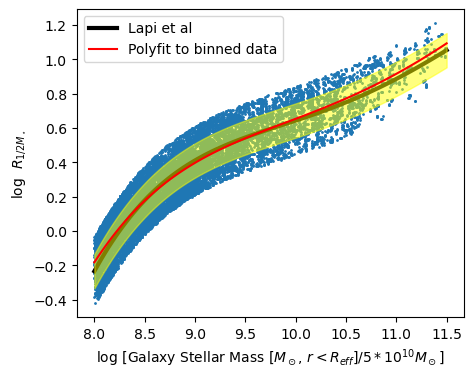

In [65]:
poly_bins=np.poly1d(np.polyfit(logms_to_plot,logr_to_plot,4))

fig=plt.figure(figsize=(5,4))
ax=fig.add_subplot(111)
ax.plot(log_ms,log_r,'.',markersize=2)
ax.plot(x_values,z(x_values),color='black',label='Lapi et al',linewidth=3)
ax.plot(x_values,poly_bins(x_values),color='red',zorder=3,label='Polyfit to binned data')
ax.fill_between(x_values,z(x_values)+0.1,z(x_values)-0.1,color='yellow',alpha=0.5,zorder=2)

ax.set_xlabel('log [Galaxy Stellar Mass [$M_\odot$, $r < R_{eff}]/5*10^{10}M_\odot$]')
ax.set_ylabel('log  $R_{1/2 M_\star}$')
ax.legend()
plt.show()

In [66]:
df=pd.DataFrame({'SubhaloID':all_id,'$z$':all_z})
df

,SubhaloID,$z$
0,8.0,0.000
1,11.0,0.000
2,17.0,0.000
3,20.0,0.000
4,37.0,0.000
...,...,...
16143,829320.0,0.049
16144,831921.0,0.049
16145,835574.0,0.049
16146,840328.0,0.049


In [68]:
df.to_csv('IDs0-0.05.csv')

In [105]:
def dump_to_csv(snapr):
    
    rs=np.round(snapr[1],3)
    sub_ids=df[df['$z$']==rs]['SubhaloID'].to_numpy().astype(int)
    a=1/(1+rs)
    
    full_data=il.groupcat.loadSubhalos(basePath,snapr[0],fields=['SubhaloMassType','SubhaloHalfmassRad','SubhaloHalfmassRadType','SubhaloMass','SubhaloSFR','SubhaloVmax','SubhaloVelDisp'])
    print('Data Loaded')
    mg=full_data['SubhaloMassType'][sub_ids][:,0]*1e10/h
    ms=full_data['SubhaloMassType'][sub_ids][:,4]*1e10/h
    mdm=full_data['SubhaloMassType'][sub_ids][:,1]*1e10/h
    shmr=full_data['SubhaloHalfmassRadType'][sub_ids][:,4]*a/h
    thmr=full_data['SubhaloHalfmassRad'][sub_ids]*a/h
    sfr=full_data['SubhaloSFR'][sub_ids]
    v=full_data['SubhaloVmax'][sub_ids]
    s=full_data['SubhaloVelDisp'][sub_ids]
    tm=full_data['SubhaloMass'][sub_ids]*1e10/h
    rs=np.full((len(mg)),rs)
    
    df2=pd.DataFrame({'SubhaloID':sub_ids,'$M_{gas},M_{\odot}$':mg,'$M_{stellar},M_{\odot}$':ms,'$M_{DM},M_{\odot}$':mdm,'$R_{1/2M_{sub}}$(kpc)':thmr,'SFR($M_{\odot}/yr$)':sfr,'$V_{max}$(km/s)':v,'$\sigma_v$(km/s)':s,
                'M':tm,'z':rs,'$R_{1/2M_*}$':shmr})

    df2.to_csv('SUBHALOS_0-0.05.csv',mode='a')
        
    print('Successful')

In [109]:
def dump_to_csv(snapr):
    rs = np.round(snapr[1], 3)
    sub_ids = df[df['$z$'] == rs]['SubhaloID'].to_numpy().astype(int)
    a = 1 / (1 + rs)

    full_data = il.groupcat.loadSubhalos(basePath, snapr[0], fields=['SubhaloMassType', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloMass', 'SubhaloSFR', 'SubhaloVmax', 'SubhaloVelDisp'])
    print('Data Loaded')

    mg = full_data['SubhaloMassType'][sub_ids][:, 0] * 1e10 / h
    ms = full_data['SubhaloMassType'][sub_ids][:, 4] * 1e10 / h
    mdm = full_data['SubhaloMassType'][sub_ids][:, 1] * 1e10 / h
    shmr = full_data['SubhaloHalfmassRadType'][sub_ids][:, 4] * a / h
    thmr = full_data['SubhaloHalfmassRad'][sub_ids] * a / h
    sfr = full_data['SubhaloSFR'][sub_ids]
    v = full_data['SubhaloVmax'][sub_ids]
    s = full_data['SubhaloVelDisp'][sub_ids]
    tm = full_data['SubhaloMass'][sub_ids] * 1e10 / h
    rs = np.full((len(mg)), rs)

    df2 = pd.DataFrame({'SubhaloID': sub_ids, '$M_{gas},M_{\odot}$': mg, '$M_{stellar},M_{\odot}$': ms, '$M_{DM},M_{\odot}$': mdm, '$R_{1/2M_{sub}}$(kpc)': thmr, 'SFR($M_{\odot}/yr$)': sfr, '$V_{max}$(km/s)': v, '$\sigma_v$(km/s)': s,
                        'M': tm, 'z': rs, '$R_{1/2M_*}$': shmr})

    csv_file_path = 'SUBHALOS_0-0.05.csv'

    if not os.path.isfile(csv_file_path):
        df2.to_csv(csv_file_path, mode='w', index=False, header=True)
    else:
        df2.to_csv(csv_file_path, mode='a', index=False, header=False)

    print('Successful')

In [111]:
for snapr in snaprs[95:][::-1]:
    dump_to_csv(snapr)

Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful


In [107]:
doo=pd.read_csv('SUBHALOS_0-0.05.csv')
doo

,Unnamed: 0,SubhaloID,"$M_{gas},M_{\odot}$","$M_{stellar},M_{\odot}$","$M_{DM},M_{\odot}$",$R_{1/2M_{sub}}$(kpc),SFR($M_{\odot}/yr$),$V_{max}$(km/s),$\sigma_v$(km/s),M,z,$R_{1/2M_*}$
0,0.0,4,42432700000.0,34536410000.0,559720500000.0,66.64449,5.7960525,188.71819,90.23391,636768600000.0,0.049,4.819926
1,1.0,19,19805930000.0,4770331600.0,197741260000.0,41.71793,0.52995586,115.152115,61.448765,222334340000.0,0.049,5.26749
2,2.0,20,4160346000.0,18284220000.0,153542740000.0,18.729542,0.44360855,153.52353,82.92617,176042260000.0,0.049,4.0660596
3,3.0,29,7923507700.0,3500112100.0,124750725000.0,30.816628,0.51271033,102.70284,55.269012,136183080000.0,0.049,4.407003
4,4.0,34,6837388300.0,3776447500.0,112811300000.0,30.774761,0.25536442,96.56794,51.79644,123435170000.0,0.049,5.2016077
...,...,...,...,...,...,...,...,...,...,...,...,...
16147,3182.0,840044,1152603800.0,153177000.0,18511940000.0,18.982832,0.018479763,48.31115,26.157375,19817722000.0,0.0,0.520848
16148,3183.0,849721,347010750.0,310545120.0,16486870000.0,13.913523,0.02386134,53.125504,27.782812,17144425000.0,0.0,1.4246974
16149,3184.0,850125,815446850.0,174013100.0,16643866000.0,17.15043,0.011943535,51.879505,26.623268,17633325000.0,0.0,0.9077584
16150,3185.0,851835,364652320.0,145223120.0,18726562000.0,14.915457,0.015638888,54.164833,28.93423,19236438000.0,0.0,0.64110315


In [108]:
doo['SubhaloID']

0             4
1            19
2            20
3            29
4            34
          ...  
16147    840044
16148    849721
16149    850125
16150    851835
16151    854247
Name: SubhaloID, Length: 16152, dtype: object